# Surrogate Model Exploration
I wanted to see whether using a direct optimizer mattered.  The answer is it doesn't.  But what does matter is the kernel. 

In [3]:
%load_ext autoreload
%autoreload 2

In [10]:
#Import packages
from summit.models import GPyModel
import GPy
from surrogate_model_functions import DirectOpt, plot_3d, loo_error
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#Create test problem
rs = np.random.RandomState(100)
x = rs.rand(100, 2)
x = -5 + x*10
#6 humped camel function
def f(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    f = (4 - 2.1*(x1*x1) + (x1*x1*x1*x1)/3.0)*(x1*x1) + x1*x2 + (-4 + 4*(x2*x2))*(x2*x2)
    return np.atleast_2d(f).T
y = f(x)

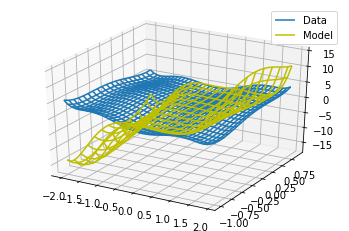

In [13]:
#Set up a standard GP model
kern = GPy.kern.Matern52(input_dim=2, ARD=True)
m1 = GPy.models.GPRegression(x, y, kernel=kern)
plot_3d(f, m1) 

The plot above shows the model before it is optimized - not looking so hot.

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract


LOO CV error when using a basic kernel and the bfgs optimizer: 24.0%


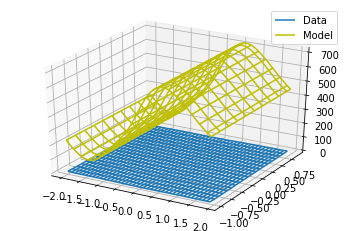

In [14]:
#Now let's optimize the model with the default bfgs optimizater
m1.optimize()
plot_3d(f, m1)
error_bfgs = loo_error(x,y, kernel=kern)
print(f"LOO CV error when using a basic kernel and the bfgs optimizer: {round(error_bfgs*100)}%")

The optimization actually makes the model worse!

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Us

LOO CV error when using a basic kernel and the direct optimizer: 13.0%


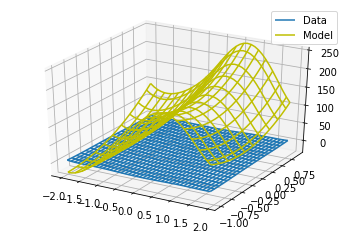

In [15]:
#Now let's try optimizing using the direct search optimizer
m2 =  GPy.models.GPRegression(x, y, kernel=kern)
bounds = 3*[(0, 1e3)]
m2.optimize(DirectOpt(bounds))
plot_3d(f, m2)
error_direct = loo_error(x,y, optimizer=DirectOpt(bounds), kernel=kern)
print(f"LOO CV error when using a basic kernel and the direct optimizer: {round(error_direct*100)}%")

Fortunately, there is a solution.  The problem isn't with the optimizer. It's with the kernel.  When you look at the data itself it's got lots of local maxima and minima (hence the name 6-humped camel). So, you really need a multiplicative kernel to capture all of those stationary points. 

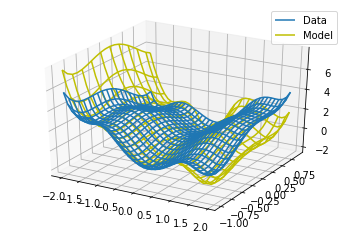

In [19]:
kern1 = GPy.kern.Matern52(input_dim=2, ARD=True)
kern2 = GPy.kern.Matern52(input_dim=2, ARD=True)
product_kern = kern1*kern2
m3 = GPy.models.GPRegression(x, y, kernel=product_kern)
m3.optimize()
plot_3d(f, m3)
plt.savefig('outputs/six_humped_camel_good_fit.png')
plt.savefig('outputs/six_humped_camel_good_fit.svg')

In [18]:
error_with_product = loo_error(x, y, kernel=product_kern)
print(f"LOO CV error when using a product kernel: {round(error_with_product*100)}%")


 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


LOO CV error when using a product kernel: 1.0%


<Figure size 432x288 with 0 Axes>